<a href="https://colab.research.google.com/github/JebediahDean/IS_4487_Tokyo/blob/main/Jeb_day7_lab_megatelco_tree_model(II).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 7 Lab, IS 4487

The purpose of this Lab is to prepare you to complete today's project quiz. Here are the questions you need to be able to answer.

- Fit a tree model of the target using *all the predictors*, then:  create a visualization of the tree and identify the top 3 most important predictors in this model.
    
- How do these models compare to majority class prediction?

- How do they compare to the simpler model created in the previous project assignment.
    
- How will you use a classification model as part of a solution to the AdviseInvest case?



##Load Libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Import packages needed for the classification tree
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz # Import Decision Tree Classifier



## Get data


In [2]:
mtc = pd.read_csv("https://raw.githubusercontent.com/jefftwebb/is_4487_base/dd870389117d5b24eee7417d5378d80496555130/Labs/DataSets/megatelco_leave_survey.csv")

## Clean  data

Perform the cleaning from the previous labs:

- Make a copy of the data
- Remove negative values of income and house
- Remove absurdly large value of handset_price
- Remove NAs
- Change college to yes and no
- Make string variables into categorical variables. To use in the tree algorithm we also need to convert the now ordered levels into integers. (DecisionTreeClassifier requires all numeric inputs.)




In [3]:
# Make explicit copy
mtc_clean = mtc.copy()

# filter rows
mtc_clean = mtc[(mtc['house'] > 0) & (mtc['income'] > 0) & (mtc['handset_price'] < 1000)]

# remove NAs
mtc_clean = mtc_clean.dropna()

# Recode college
mtc_clean['college'] = mtc_clean['college'].replace({'one': 'yes', 'zero': 'no'})

The next step is to make the categorical variables into integers that correspond to the order of the levels.

This procedure requires just a small tweak to code from the previous lab.  We add `.codes` onto the end of `pd.Categorical()` function. Though oddly named, this function returns the integer codes (positions) of the categories for each value in the Categorical series.

Here's an example:

In [4]:
# without .codes
pd.Categorical(['low', 'high', 'medium', 'low'],
                   categories=['low', 'medium', 'high'],
                   ordered=True)

['low', 'high', 'medium', 'low']
Categories (3, object): ['low' < 'medium' < 'high']

In [5]:
# with .codes
pd.Categorical(['low', 'high', 'medium', 'low'],
                   categories=['low', 'medium', 'high'],
                   ordered=True).codes

array([0, 2, 1, 0], dtype=int8)

Remember that some of the categorical variables are ordered and some aren't.

In [6]:
# change reported usage and reported satisfaction (ordered)
mtc_clean['college'] = pd.Categorical(mtc_clean['college'],
                                    ordered = False).codes

mtc_clean['considering_change_of_plan'] = pd.Categorical(mtc_clean['considering_change_of_plan'],
                                    ordered = False).codes

# change reported usage and reported satisfaction (ordered)
mtc_clean['reported_usage_level'] = pd.Categorical(mtc_clean['reported_usage_level'],
                                    categories = ['low', 'avg','high'],
                                    ordered = True).codes

mtc_clean['reported_satisfaction'] = pd.Categorical(mtc_clean['reported_satisfaction'],
                                    categories = ['low', 'avg','high'],
                                    ordered = True).codes

## Fit a full tree model

Use all of the variables.  We'll call this the "full tree." We will use `max_depth = 4` to keep the tree relatively simple but still include sufficient complexity.

We need to undertake a couple of last data preparation steps.  

1. We will use cross-validation to assess whether the model is overfitting.  Therefore, we will split the dataset into train and test sets, and make sure to evaluate model accuracy on the test set.

2. Since we will be using all of the predictors in the `X` predictor matrix we need to make sure to omit  `id` and `leave` and define `y` as `leave`.



In [7]:
# 1. divide mtc_clean into train and test
train = mtc_clean.sample(frac=0.8, random_state=200) # 80% of data for training
test = mtc_clean.drop(train.index) # the remaining 20%


# 2. Define X and y in train and test
X_train = train.drop(['id', 'leave'], axis = 1)
y_train = train['leave']

X_test = test.drop(['id', 'leave'], axis = 1)
y_test = test['leave']

Now, fit the tree--call it `full_tree`-- using `X_train` and `y_train` with `max_depth = 4`:

In [8]:
# Initialize the tree
full_tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 4)

# Fit the model
full_tree = full_tree.fit(X=X_train, y=y_train)


##Visualize the full tree

[Text(0.5, 0.875, 'house <= 600255.5\nentropy = 1.0\nsamples = 3995\nvalue = [1984, 2011]\nclass = LEAVE'),
 Text(0.25, 0.625, 'overage <= 97.5\nentropy = 0.976\nsamples = 2618\nvalue = [1546, 1072]\nclass = STAY'),
 Text(0.125, 0.375, 'leftover <= 24.5\nentropy = 1.0\nsamples = 1751\nvalue = [857, 894]\nclass = LEAVE'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'handset_price <= 133.5\nentropy = 0.732\nsamples = 867\nvalue = [689, 178]\nclass = STAY'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'income <= 99826.0\nentropy = 0.902\nsamples = 1377\nvalue = [438, 939]\nclass = LEAVE'),
 Text(0.625, 0.375, 'college <= 0.5\nentropy = 0.681\nsamples = 909\nvalue = [164, 745]\nclass = LEAVE'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'overage <= 54.5\nentropy = 0.979\nsamples = 468\nvalue = [274, 194]\nclass = STAY'),
 Text(0.8

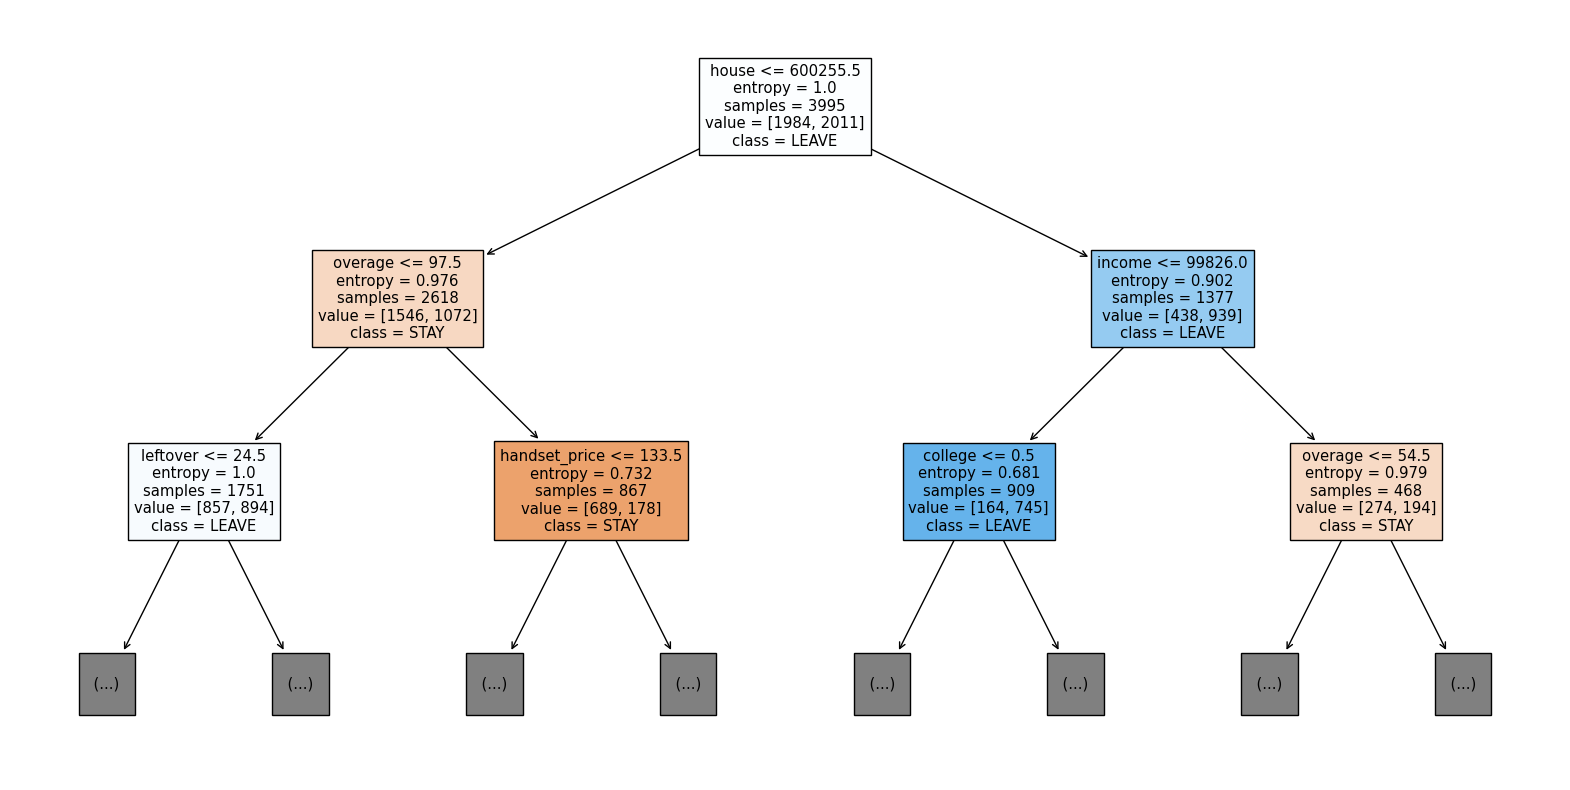

In [9]:
#Adjust the size of the visualization
plt.figure(figsize=(20,10))

# Plot the tree with feature names and class names
plot_tree(full_tree,
          feature_names = X_train.columns,
          class_names=['STAY', 'LEAVE'],
          filled=True,
          max_depth=2) # reduce depth for legibility



What are the most important predictors of churn based on this model?

## Check Accuracy

How is the model performing?

In [10]:
# Retrieve Predictions using the train set
y_pred_train = full_tree.predict(X_train)

In [11]:
# Check accuracy of the model on the train set
(y_train == y_pred_train).sum()/ len(y_train)

0.7103879849812266


Is overfitting taking place?  Check accuracy when predicting on the test set.

In [12]:
# Retrieve predictions from the model using the test set
y_pred_test = full_tree.predict(X_test)

In [13]:
# Check accuracy on the test set
(y_test == y_pred_test).sum()/ len(y_test)


0.6926926926926927

Comment on:

1. Overfitting.  Compare train and test accuracy.  These should not be very different. (Remember that the complicated model from the previous lab--without the `max_depth()` setting--went from accuracy of .98 on the train set to .52 on the test set.

2. Performance. Is this model doing better than the majority class classifier?  Is it doing better than the simple models from the previous lab as measured by accuracy on the test set?

1) The train accuracy is 71.04 percent and the test accuracy is 69.27 percent. This means that the model preforms well on new data meaning it is not uner nor overfit but just right. The difference in the performance, about 2% can be explaned by natrual varience in the data.

2) Yes, this model is doing better than both the majority class classifier and the previous model which had a performance of about 50%.

## Mini Project

You have applied for an internship in a new business analytics division at Goldman Sachs.  Traditionally finance companies have used Excel.  The new division is designed to increase the number of GS employees who are able to do advanced analytics using python. As part of your application you been given a data science challenge: create a model of default using the dataset below.  

You need to answer these questions:

1. What is the top predictor of default in your model?  
2. How accurate is your model?
3. Is your model overfitting?

In each case explain how you got your answer.

In [14]:
df = pd.read_csv("https://raw.githubusercontent.com/jefftwebb/IS_4487_Tokyo/main/Default.csv")

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Cleaning

In [16]:
df.describe()

,id,balance,income
count,10000.00000,10000.000000,10000.000000
mean,5000.50000,835.374886,33516.981876
std,2886.89568,483.714985,13336.639563
min,1.00000,0.000000,771.967729
25%,2500.75000,481.731105,21340.462905
50%,5000.50000,823.636973,34552.644800
75%,7500.25000,1166.308387,43807.729275
max,10000.00000,2654.322576,73554.233500


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       10000 non-null  int64  
 1   default  10000 non-null  object 
 2   student  10000 non-null  object 
 3   balance  10000 non-null  float64
 4   income   10000 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 390.8+ KB


In [18]:
df

,id,default,student,balance,income
0,1,No,No,729.526495,44361.62507
1,2,No,Yes,817.180407,12106.13470
2,3,No,No,1073.549164,31767.13895
3,4,No,No,529.250605,35704.49394
4,5,No,No,785.655883,38463.49588
...,...,...,...,...,...
9995,9996,No,No,711.555020,52992.37891
9996,9997,No,No,757.962918,19660.72177
9997,9998,No,No,845.411989,58636.15698
9998,9999,No,No,1569.009053,36669.11236


In [19]:
df_cleaning = df.copy()

#### Dropping Irelevant Predictors

In [20]:
df_cleaning = df_cleaning.drop(['id'], axis = 1)

#### Making Student Numeric

In [21]:
df_cleaning["student"] = df_cleaning["student"].replace({'Yes': 1, 'No': 0})

#### Final Copy

In [22]:
df_cleaning

,default,student,balance,income
0,No,0,729.526495,44361.62507
1,No,1,817.180407,12106.13470
2,No,0,1073.549164,31767.13895
3,No,0,529.250605,35704.49394
4,No,0,785.655883,38463.49588
...,...,...,...,...
9995,No,0,711.555020,52992.37891
9996,No,0,757.962918,19660.72177
9997,No,0,845.411989,58636.15698
9998,No,0,1569.009053,36669.11236


In [23]:
df_clean = df_cleaning.copy()

### Data Modeling

In [24]:
# Split into test and train
train = df_clean.sample(frac=0.8, random_state=200)
test = df_clean.drop(train.index)

In [25]:
# Initialize the decision tree classifier
dtc = DecisionTreeClassifier(criterion="entropy", max_depth=5)

In [26]:
# Fit the tree
dtc = dtc.fit(X=train.drop(['default'], axis = 1), y=train['default'])

In [27]:
# Get predictions for train set, calculate accuracy
y_train_pred = dtc.predict(train.drop(['default'], axis = 1))
(train['default'] == y_train_pred).sum()/ len(train)

0.97575

In [28]:
# Get predictions for test set, calculate accuracy
y_test_pred = dtc.predict(test.drop(['default'], axis = 1))
(test['default'] == y_test_pred).sum()/ len(test)

0.9755

## Functions

- `pd.read_csv()`: Reads a CSV file into a pandas DataFrame
- `dropna()`: Removes rows with missing values from a DataFrame
- `replace()`: Replaces one value with another in a series
- `drop()`: Removes specified columns in a DataFrame
- `pd.Categorical().codes`: Sets categorical levels and returns integers based on those levels.
- `sample()`: creates a random sample of a data frame.
- `DecisionTreeClassifier()`: Creates a decision tree classifier
- `fit()`: Builds a decision tree classifier from the training set (`X`, `y`)
- `plt.figure()`: Creates a new figure or activates an existing figure in matplotlib
- `plot_tree()`: Plots a decision tree
- `plt.show()`: Displays all open figures
- `predict()`: Predicts class labels for samples in X
- `sum()`: Returns the sum of a sequence of numbers
- `len()`: Returns the number of items in an object